# Self-Driving Car Engineer Nanodegree


## Project: Advanced Lane Finding
---
The goal of this project is to create a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. 

The steps of the project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
 

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

The following code calculates the camera matrix and distortion coefficients using the images in the *"camera_cal"* folder. It was adopted from original Udacity [source](https://github.com/udacity/CarND-Camera-Calibration)

First import the libraries and define a `Line()` class to keep track of all the parameters of the measurements.

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline

# Define a class to receive the characteristics of each line detection
class Line():
    # Camera calibration params
    #calibration matrix
    mtx = None
    #distortion coefficients
    dist = None

    # Perspective transform params
    #source points
    src_tl = None
    src_tr = None
    src_br = None
    src_ll = None
    src = None
    
    #destination points
    dst_tl = None
    dst_tr = None
    dst_br = None
    dst_ll = None
    dst = None
    
    #transform matrix
    M = None
    #inverse matrix
    Minv = None
    
    first_frame = True
    left_fit = None
    right_fit = None

    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
# Create an instance of class Line() to keep a track of the measurements
line = Line()

Use OpenCV library to extract object points `objpoints` and image points `imgpoints` needed for camera calibration.
Then, calibrate, calculate distortion coefficients. The camera calibration matrix and distortion coefficients are saved in file `camera_cal/dist_pickle.p` and in the instance of the 'Line()' class.

In [2]:
# number of inside corners in x and y
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Keep filenames of image with not found corners to test camera calibration 
test_fnames = []
                 
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    # Read a file
    img = cv2.imread(fname)
    # Covert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # get filename
    filename = fname.split('\\')[-1]
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        write_name = 'camera_cal/'+'corners_'+filename
        cv2.imwrite(write_name, img)
        cv2.waitKey(500)
    else:
        test_fnames.append(fname)

img = cv2.imread('camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
line.mtx = mtx
line.dist = dist
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )

print('Number of images with detected corners =', len(imgpoints))
print('Number of images with not detected corners =', len(test_fnames))

Number of images with detected corners = 17
Number of images with not detected corners = 3


Visualization help functions

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def plt_one(image, title = None, cmap=None):
    figure, ax = plt.subplots(figsize=(9, 6))
    ax.imshow(image, cmap=cmap)
    ax.set_title(title)
    plt.show()
    return figure
    
def plt_two(image_1, image_2, title_1 = None, title_2 = None, cmap=None):
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image_1)
    ax1.set_title(title_1, fontsize=30)
    ax2.imshow(image_2, cmap=cmap)
    ax2.set_title(title_2, fontsize=30)
    plt.show()
    return figure

A chessboard image with detected corners

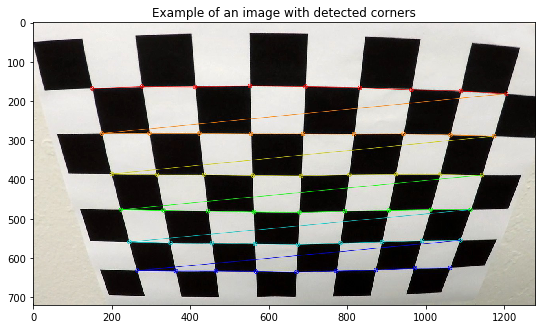

In [4]:
image = cv2.imread('camera_cal/corners_calibration2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

figure = plt_one(image, "Example of an image with detected corners")
figure.savefig('output_images/test_chessboard.jpg')   # save the figure to file
plt.close(figure)    # close the figure

In 3 images the corners could not be detected because the number of cross points is not corresponding to the defined values of nx = 9 and ny = 6. I will use those images to test undistortion. 

### 2. Apply a distortion correction to raw images

First test a chessboard image

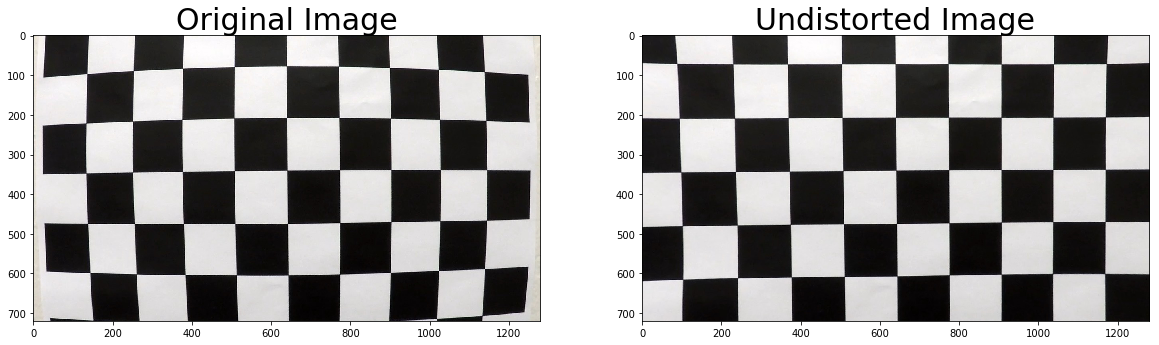

In [5]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def undistort(image, dist_pickle_fname):
    """
    The function reads in the saved camera matrix and distortion coefficients
    and undistort the input image
    Returns an undistorted image "undist"
    """    
    # Read in the saved camera matrix and distortion coefficients
    #dist_pickle = pickle.load( open(dist_pickle_fname, "rb"))
    #mtx = dist_pickle["mtx"]
    #dist = dist_pickle["dist"]        
    # Undistort using mtx and dist
    #undist = cv2.undistort(image, mtx, dist, None, mtx)
    undist = cv2.undistort(image, line.mtx, line.dist, None, line.mtx)
    return undist

# Test on chessboard image
image = cv2.imread(test_fnames[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#undist = undistort(image, "camera_cal/dist_pickle.p")
undist = cv2.undistort(image, line.mtx, line.dist, None, line.mtx)

# Visualize undistortion
figure = plt_two(image, undist, 'Original Image', 'Undistorted Image')
figure.savefig('output_images/test_calibration.jpg')   # save the figure to file
plt.close(figure)    # close the figure

Now apply undistortion to raw images

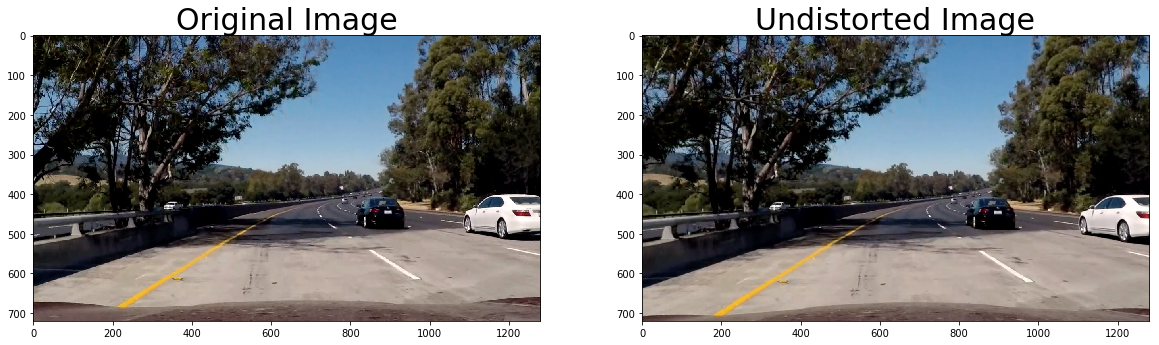

In [6]:
# Test on a raw test image
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undist = cv2.undistort(image, line.mtx, line.dist, None, line.mtx)

# Visualize undistortion
figure = plt_two(image, undist, 'Original Image', 'Undistorted Image')
figure.savefig('output_images/test_undistortion.jpg')   # save the figure to file
plt.close(figure)    # close the figure

### 3. Use color transforms, gradients, etc., to create a thresholded binary image

It's not clear what exactly the best result should be - have to figure out later on

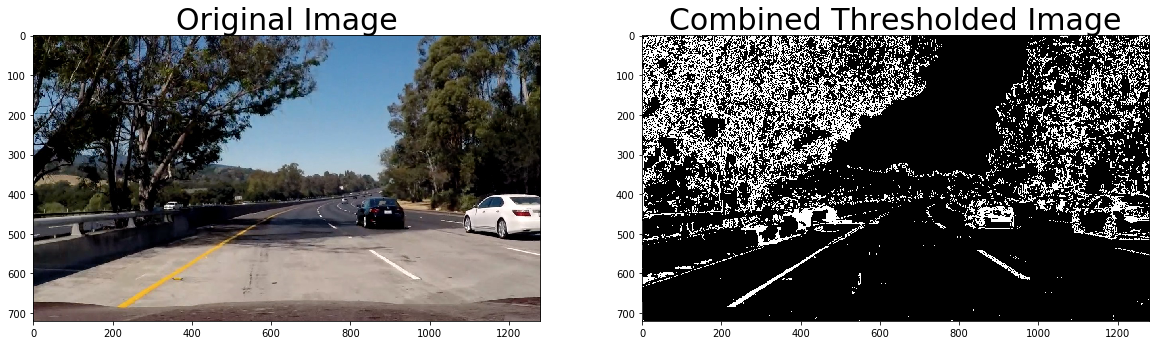

In [7]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)        
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)   
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    # Apply threshold
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    grad_binary = np.copy(sxbinary) 
    # Apply threshold
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    # Apply threshold
    sxbinary = np.zeros_like(gradmag)
    sxbinary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    mag_binary = np.copy(sxbinary)
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    # Apply threshold
    sxbinary = np.zeros_like(grad_dir)
    sxbinary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    dir_binary = np.copy(sxbinary)
    return dir_binary

def combined_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.uint8(color_binary)    
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary   

combined = combined_binary(image)

# Visualize binary image
figure = plt_two(image, combined, 'Original Image', 'Combined Thresholded Image', cmap='gray')
figure.savefig('output_images/combined_treshold_binary.jpg')   # save the figure to file
plt.close(figure)    # close the figure

### 4. Apply a perspective transform to rectify binary image ("birds-eye view")

First draw lines on the test image to find corners for perspective transform. Use straight line to check if the output lines are drawing a rectangle. Draw lines on top of the lane lines.

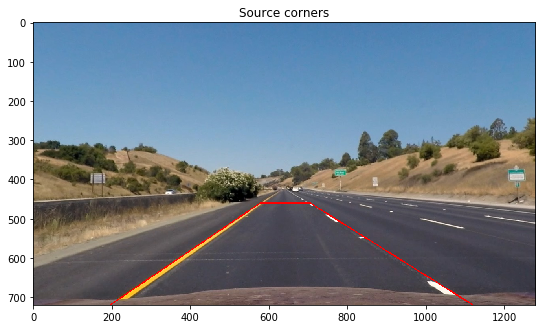

In [8]:
# Read a test image
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Remove distortion
#image = undistort(image, "camera_cal/dist_pickle.p")
undist = cv2.undistort(image, line.mtx, line.dist, None, line.mtx)


def mark_lines(image, col=[255,0,0], thick=1):
    # Draw lines on the image
    cv2.line(image, line.src_tl, line.src_tr, color=col, thickness=thick)
    cv2.line(image, line.src_tr, line.src_br, color=col, thickness=thick)
    cv2.line(image, line.src_br, line.src_bl, color=col, thickness=thick)
    cv2.line(image, line.src_bl, line.src_tl, color=col, thickness=thick)
    return image

# Define corner points and save inthe line instance
# top-left
tl_x = 578
tl_y = 460          
line.src_tl = (tl_x, tl_y)

# top-right
tr_x = 705
tr_y = 460
line.src_tr = (tr_x, tr_y)

# bottom-right
br_x = 1120
br_y = image.shape[0]
line.src_br = (br_x, br_y)

# bottom-left
bl_x = 195
bl_y = image.shape[0]  
line.src_bl = (bl_x, bl_y)

# Test mark lines on the image
marked_image = mark_lines(undist, thick=2)
 
# Visualize mark lines
figure = plt_one(marked_image, "Source corners")
plt.close(figure)    # close the figure
figure.savefig('output_images/mark_straight_lines.jpg')   # save the figure to file
plt.close(figure)    # close the figure

The line are ok, now do the perspective transform. The source points are the end points of the drawn lines. The destination points are the outer corners of the image minus an offset of 200 pixels. The order of the corners will be: top-left->top-right->bottom-right->bottom-left.

First use the straight lines image to get parameters of the perspective transform.

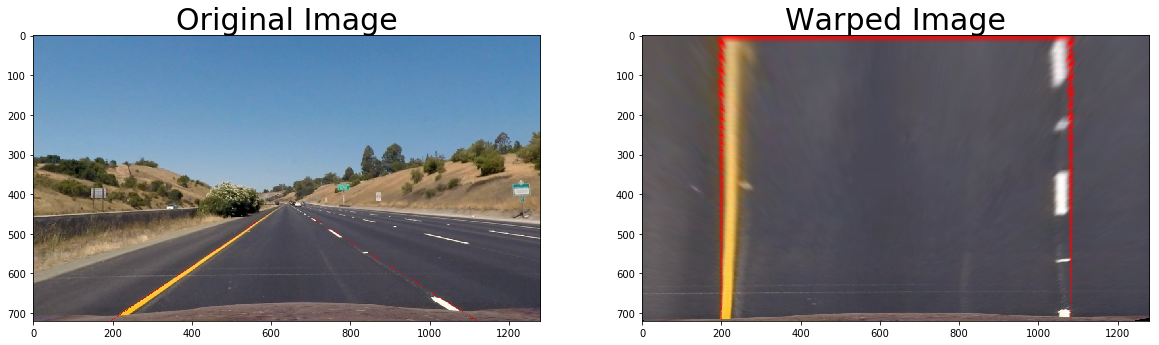

In [9]:
# Read a test image
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Remove distortion
#image = undistort(image, "camera_cal/dist_pickle.p")
undist = cv2.undistort(image, line.mtx, line.dist, None, line.mtx)

# Binary thresholded image
binary = combined_binary(undist)
image_size = (binary.shape[1], binary.shape[0])
width, height = image_size
offset = 200

# Define corner points
tl = [tl_x, tl_y]  # top-left
tr = [tr_x, tr_y]  # top-right
br = [br_x, br_y]  # bottom-right
bl = [bl_x, bl_y]  # bottom-left

# define sorce and destination points
line.src = np.float32([tl,tr,br,bl])
line.dst = np.float32([[offset, 0], [image_size[0] - offset, 0], [image_size[0] - offset, image_size[1]], [offset, image_size[1]]])

# Draw lines on the image
marked_image = mark_lines(undist, thick=1)

# get the transform matrix M
line.M = cv2.getPerspectiveTransform(line.src, line.dst)
# get inverse transform matrix Minv
line.Minv = cv2.getPerspectiveTransform(line.dst, line.src)

# Warp to top-down view
warped = cv2.warpPerspective(marked_image, line.M, (width, height), flags=cv2.INTER_LINEAR)

# Visualize perspective transform
figure = plt_two(marked_image, warped, 'Original Image', 'Warped Image')
figure.savefig('output_images/test_warped.jpg')   # save the figure to file
plt.close(figure)    # close the figure

Now test it on a binary thresholded image of curved lanes

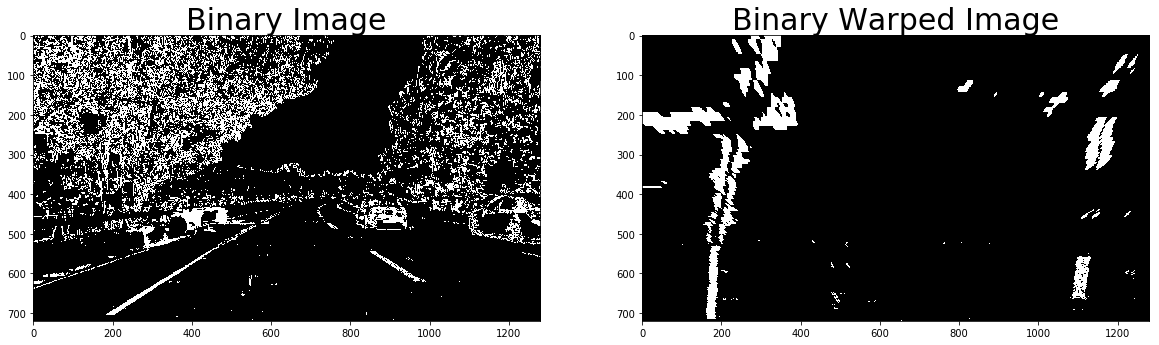

In [10]:
# Read a test image
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Remove distortion
#undist = undistort(image, "camera_cal/dist_pickle.p")
undist = cv2.undistort(image, line.mtx, line.dist, None, line.mtx)
binary = combined_binary(undist)
img_size = (binary.shape[1], binary.shape[0])
width, height = img_size

# Warp to top-down view
binary_warped = cv2.warpPerspective(binary, line.M, (width, height), flags=cv2.INTER_LINEAR)

# Visualize perspective transform
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(binary, cmap='gray')
ax1.set_title('Binary Image', fontsize=30)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Binary Warped Image', fontsize=30)
plt.show()
figure.savefig('output_images/binary_warped.jpg')   # save the figure to file
plt.close(figure)    # close the figure

### 5. Detect lane pixels and fit to find the lane boundary

Take a histogram along all the columns in the lower half of a binary warped image:

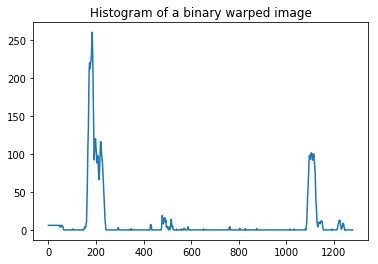

In [12]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
figure, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
ax.plot(histogram)
ax.set_title("Histogram of a binary warped image")
plt.show()
figure.savefig('output_images/histogram.jpg')   # save the figure to file
plt.close(figure)    # close the figure

The two most prominent peaks in the histogram indicate the x-position of the base of the lane lines. Use that as a starting point for where to search for the lines. From that point use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

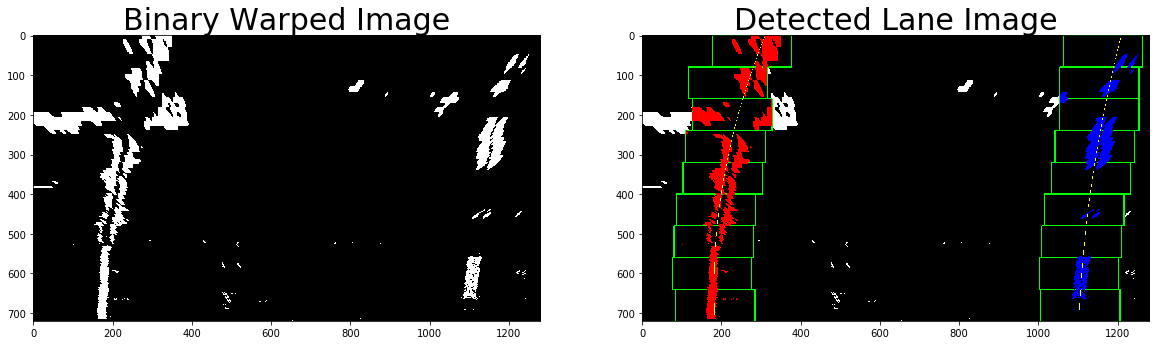

In [13]:
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Finding peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Number of sliding windows
nwindows = 9

# Height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identifing the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Margin in which to search
margin = 100

# Minimum number of pixels found to recenter window
minpix = 50

# Empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Steping through windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Drawing the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identifing the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
    # Appending these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # Recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenating the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extracting left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

## Visualization
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
for i in range(len(ploty)):
    out_img[i, int(left_fitx[i])] = [255, 255, 0]
    out_img[i, int(right_fitx[i])] = [255, 255, 0]

# Visualize perspective transform
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Binary Warped Image', fontsize=30)
ax2.imshow(out_img, cmap='gray')
ax2.set_title('Detected Lane Image', fontsize=30)
plt.show()
figure.savefig('output_images/detected_lane.jpg')   # save the figure to file
plt.close(figure)    # close the figure

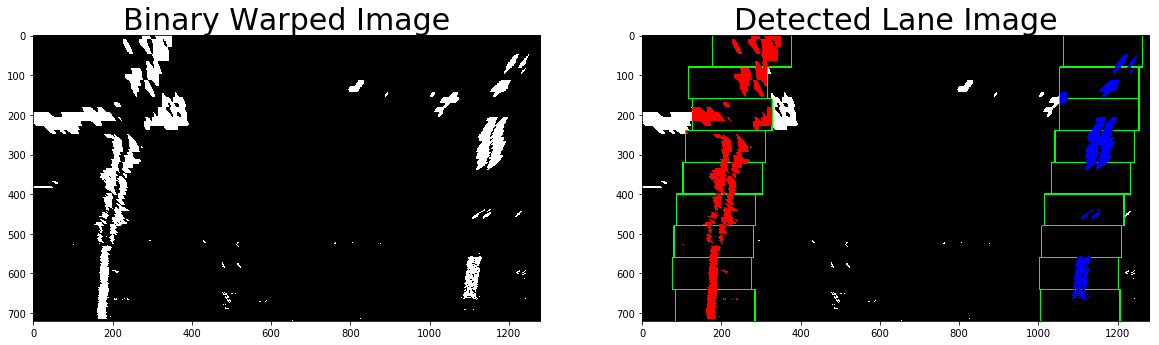

In [14]:
def find_lines(image, first_frame=True, max_fit_error=0.01):

    binary_warped = np.copy(image)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50  
   
    if first_frame:
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
    
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
    
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
        
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2) 
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2) 
    
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
        
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # save fits of the first frame
        line.left_fit = left_fit
        line.right_fit = right_fit
        line.first_frame = False
    else:
        # Consequtive frame
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_fit = line.left_fit
        right_fit = line.right_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
            
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2) 
        
        # Update fits only if the error is less than the tolerance
        left_error = ((line.left_fit[0] - line.left_fit[0]) ** 2).mean(axis=None)      
        if left_error < max_fit_error:
            line.left_fit = 0.75 * line.left_fit + 0.25 * left_fit   
        # update right fit
        right_error = ((line.right_fit[0] - line.right_fit[0]) ** 2).mean(axis=None)        
        if right_error < max_fit_error:
            line.right_fit = 0.75 * line.right_fit + 0.25 * right_fit


    # Get left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img

# load test image
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# get binary_warped
undist = cv2.undistort(image, line.mtx, line.dist, None, line.mtx)
binary = combined_binary(undist)    
width  = binary.shape[1]
height = binary.shape[0]
binary_warped = cv2.warpPerspective(binary, line.M, (width, height))

# Find lines
output = find_lines(binary_warped) 

# Visualize perspective transform
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Binary Warped Image', fontsize=30)
ax2.imshow(output, cmap='gray')
ax2.set_title('Detected Lane Image', fontsize=30)
plt.show()
figure.savefig('output_images/detected_lane.jpg')   # save the figure to file
plt.close(figure)    # close the figure# Generate x and y values for plotting

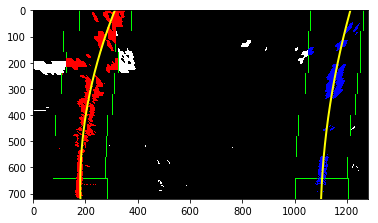

In [24]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = line.left_fit[0]*ploty**2 + line.left_fit[1]*ploty + line.left_fit[2]
right_fitx = line.right_fit[0]*ploty**2 + line.right_fit[1]*ploty + line.right_fit[2]

plt.imshow(output)
plt.plot(left_fitx, ploty, color='yellow', linewidth=2)
plt.plot(right_fitx, ploty, color='yellow', linewidth=2)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/detected_lane-lines.jpg')
plt.show()

### 6. Determine the curvature of the lane and vehicle position with respect to center

In [16]:
# Define y-value where we want radius of curvature
# as the maximum y-value, corresponding to the bottom of the image
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

left_fitx = line.left_fit[0]*ploty**2 + line.left_fit[1]*ploty + line.left_fit[2]
right_fitx = line.right_fit[0]*ploty**2 + line.right_fit[1]*ploty + line.right_fit[2]

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

# Calculate the new radius of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
curvature =  np.mean([left_curverad, right_curverad])
print(curvature, 'm')

img_center =  binary_warped.shape[1]//2
print(img_center)
xleft = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
xright = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
lane_center = np.mean([xleft, xright])
offset_from_center = (lane_center - img_center) * xm_per_pix
print(offset_from_center, 'm')

1575.89812286 3394.3784981
515.543527844 m 1111.8811193 m
813.712323571 m
640
0.0118184377316 m


In [17]:
ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
y_eval = 700
midx = 650

y1 = (2*line.left_fit[0]*y_eval + line.left_fit[1])*xm_per_pix/ym_per_pix
y2 = 2*line.left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
print("Radius of Curvature: %f" % curvature)

Radius of Curvature: 486.073163


In [18]:
def update_measurements(image):

    binary_warped = np.copy(image)

    # Define y-value where we want radius of curvature
    # as the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    left_fitx = line.left_fit[0]*ploty**2 + line.left_fit[1]*ploty + line.left_fit[2]
    right_fitx = line.right_fit[0]*ploty**2 + line.right_fit[1]*ploty + line.right_fit[2]

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Avarage radius of curvature is in meters
    curvature =  np.mean([left_curverad, right_curverad])

    # Calculate offset from lane center
    img_center =  binary_warped.shape[1]//2
    xleft = line.left_fit[0]*(y_eval**2) + line.left_fit[1]*y_eval + line.left_fit[2]
    xright = line.right_fit[0]*(y_eval**2) + line.right_fit[1]*y_eval + line.right_fit[2]
    lane_center = np.mean([xleft, xright])
    offset_from_center = (lane_center - img_center) * xm_per_pix
    return curvature, offset_from_center

# load test image
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# get binary_warped
undist = cv2.undistort(image, line.mtx, line.dist, None, line.mtx)
binary = combined_binary(undist)    
binary_warped = cv2.warpPerspective(binary, line.M, (width, height))

curvature, offset_from_center = update_measurements(binary_warped)
print(curvature, 'm')
print(offset_from_center, 'm')

813.712323571 m
0.0118184377316 m


### 7. Warp the detected lane boundaries back onto the original image

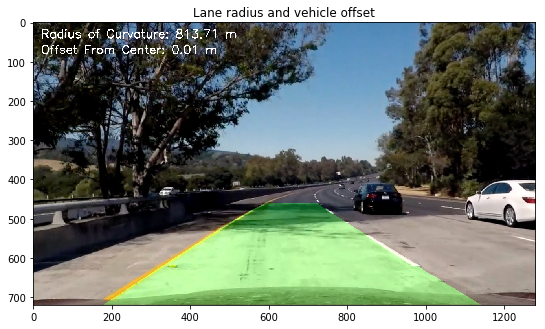

In [19]:
def draw_lane_boundary(image, undist):

    binary_warped = np.copy(image)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = line.left_fit[0]*ploty**2 + line.left_fit[1]*ploty + line.left_fit[2]
    right_fitx = line.right_fit[0]*ploty**2 + line.right_fit[1]*ploty + line.right_fit[2]

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, line.Minv, (undist.shape[1], undist.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

# load test image
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# get binary_warped
undist = cv2.undistort(image, line.mtx, line.dist, None, line.mtx)
binary = combined_binary(undist)    
width  = binary.shape[1]
height = binary.shape[0]
binary_warped = cv2.warpPerspective(binary, line.M, (width, height))
result = draw_lane_boundary(binary_warped, undist)
curvature, offset_from_center = update_measurements(binary_warped)
cv2.putText(result,'Radius of Curvature: %.2f m' % curvature, (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
cv2.putText(result,'Offset From Center: %.2f m' % offset_from_center, (20,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
 
# Visualize mark lines
figure = plt_one(result, "Lane radius and vehicle offset")
plt.close(figure)    # close the figure
figure.savefig('output_images/measurements.jpg')   # save the figure to file
plt.close(figure)    # close the figure

#plt.imshow(result)

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position


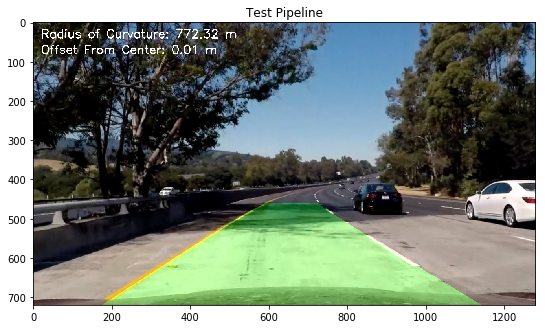

In [20]:
def pipeline(image):
    
    # Remove distortion
    undist = cv2.undistort(image, line.mtx, line.dist, None, line.mtx)
    
    # Create a thresholded binary image
    binary = combined_binary(undist)    

    # Transform to top-down view
    width  = binary.shape[1]
    height = binary.shape[0]
    binary_warped = cv2.warpPerspective(binary, line.M, (width, height))
    
    # Find lines
    output = find_lines(binary_warped, first_frame = line.first_frame)
    
    # Warp back to the original frame
    result = draw_lane_boundary(binary_warped, undist)
    
    # Update measurements
    curvature, offset_from_center = update_measurements(binary_warped)
    cv2.putText(result,'Radius of Curvature: %.2f m' % curvature, (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(result,'Offset From Center: %.2f m' % offset_from_center, (20,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    #result = np.copy(output)
    return result

# Test pipeline
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = pipeline(image)
figure = plt_one(result, "Test Pipeline")
plt.close(figure)    # close the figure
figure.savefig('output_images/test_pipeline.jpg')   # save the figure to file
plt.close(figure)    # close the figure


In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line.first_frame = True

In [26]:
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [04:06<00:00,  5.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 7s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))